In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split

import gensim
from gensim import corpora, downloader
from gensim.utils import simple_preprocess

import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from tensorflow.keras.layers import Input, BatchNormalization,concatenate, Dense, Embedding, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import Xception,preprocess_input 


2023-05-31 13:39:48.901113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
all_data = pd.read_csv("../data/X_train_update.csv", index_col='Unnamed: 0')
target = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col='Unnamed: 0')

In [3]:
all_data.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [4]:
label_encoder = preprocessing.LabelEncoder()

target_le = label_encoder.fit_transform(target['prdtypecode'].to_numpy())

In [5]:
sentences = all_data['designation']

# tokenisation
tokens = [simple_preprocess(sent, min_len = 3) for sent in sentences]

In [6]:
# calcul de la longueur max des séquences de tokens
size_tokens = map(lambda x:len(x),tokens)
max_len = max(size_tokens)

print("taille maximum des sequences de tokens :", max_len )

taille maximum des sequences de tokens : 33


In [7]:
# import de l'embedding préentrainé GLoVe dimension 100
embeddings_index = {}

f = open("../data/glove/glove.6B.100d.txt")

for line in f :
    values = line.split()
    word = values[0]
    coeffs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coeffs 
f.close()

In [8]:
# création du dicitonnaire
dictionary = corpora.Dictionary(tokens)

print("nombre de phrases traitées :", dictionary.num_docs)
print("nombre de mots traités :", dictionary.num_pos)

nombre de phrases traitées : 84916
nombre de mots traités : 696547


In [9]:
# tri du dictionnaire par ordre de fréquence d'appartion décroissante des tokens
sort_dictionary = sorted(dictionary.cfs.items(), key = lambda t : -t[1])
words = [dictionary[t[0]] for t in sort_dictionary]

# création de la matrice d'embedding de dimension 100 pour les "max_words" les plus fréquents
embedding_dim = 100
max_words = len(dictionary)+1 # on prend tout le dicitonnaire ici

embedding_matrix = np.zeros((max_words,embedding_dim))

for  i, word in enumerate(words) :
    if i < max_words :
        embedding_vector = embeddings_index.get(word)
    
    if  embedding_vector is not None :
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(60867, 100)

In [10]:
# transformation des tokens de chaque ligne en son identifiant unique dans le dicitonnaire
tokens2id = [dictionary.doc2idx(t) for t in tokens]

# padding des séquences d'ID pour qu'ils aient tous une taille de 33 (max_len)
tokens2id_pad = pad_sequences(tokens2id , maxlen =  max_len, padding = 'post')

tokens2id_pad.shape

(84916, 33)

In [11]:
tokens2id_pad[5]

array([48, 49, 51, 50, 52, 48,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [12]:
# Ajout d'un colone 'tokens2id' au df des données avant le spilt Train/Test/Valid/
all_data['tokens2id'] = pd.Series(list(tokens2id_pad))

In [13]:
all_data.head()

,designation,description,productid,imageid,tokens2id
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,"[3, 2, 6, 4, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,"[19, 14, 9, 8, 28, 20, 25, 8, 10, 21, 18, 12, ..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,"[33, 38, 31, 30, 32, 34, 39, 36, 35, 37, 0, 0,..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,"[45, 42, 43, 40, 44, 41, 0, 0, 0, 0, 0, 0, 0, ..."
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,"[46, 14, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
#Reduction de 70 % da taille du jeu de données initial (car trop d'images à traiter)
_, data, _, label = train_test_split(all_data, target_le , test_size=0.3, random_state = 42, stratify = target_le) 

In [15]:
#Split Train / Test / Valid (60 / 20 / 20)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state = 0, stratify = label) 
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_train_raw, y_train, test_size=0.2, random_state = 0, stratify = y_train) 

In [16]:
print("Taille totale du jeu reduit : {} entrées".format(len(data)))
print("Train : {} \nValidation : {} \nTest : {}".format(len(X_train_raw),len(X_valid_raw),len( X_test_raw)))

Taille totale du jeu reduit : 25475 entrées
Train : 16304 
Validation : 4076 
Test : 5095


In [17]:
X_test_raw.head()

,designation,description,productid,imageid,tokens2id
66807,New Hanging Bathroom Kitchen Utensil Box Hot R...,New Hanging Bathroom Kitchen Utensil Box Hot R...,4061618018,1283839371,"[3899, 765, 2964, 272, 7005, 1519, 2867, 20383..."
53627,The Ultimate Book Of Drawing: Essential Skills...,NaN,156428355,1215647312,"[102, 797, 1854, 21836, 9196, 15848, 4042, 316..."
50682,Leuchtturm Sf-Vordruckblätter Griechenland 201...,mit SF-Schutztaschen (100 % Polystyrol) 13er-L...,3817900394,1248843087,"[1306, 45888, 45887, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
74699,Boules De Pétanque Enfant - 6 Boules Avec Coch...,Sur de l&#39;herbe sur des cailloux ou sur le ...,3321833457,1206313316,"[9252, 21264, 413, 9252, 65, 26432, 339, 0, 0,..."
30582,Lampe 3d Football Enfants Night 7 Led Couleurs...,Lampe LED 3D Dinosaur enfants nuit 7 couleurs ...,3921185233,1263819395,"[239, 2504, 166, 739, 241, 785, 5540, 275, 235..."


In [18]:
images_dir = "../data/images/image_train/"

# liste des chemins vers les images
X_train_path = [images_dir + "image_" + str(X_train_raw.iloc[k,3]) + "_product_"+str(X_train_raw.iloc[k,2])+".jpg" for k in range(len(X_train_raw))]
X_valid_path = [images_dir + "image_" + str(X_valid_raw.iloc[k,3]) + "_product_"+str(X_valid_raw.iloc[k,2])+".jpg" for k in range(len(X_valid_raw))]
X_test_path = [images_dir + "image_" + str(X_test_raw.iloc[k,3]) + "_product_"+str(X_test_raw.iloc[k,2])+".jpg" for k in range(len(X_test_raw))]

In [19]:
image_size = 299 # Modèle Xception
batch_size = 32
prefetch_factor = tf.data.experimental.AUTOTUNE 

In [20]:
# fonction pour le chargement des images sans augmentation
def load_image(filepath) :
    # Chargement de l'image du df en mémoire
    im = tf.io.read_file(filepath)
    
    # Décodage de l'info dans un tenseur RGB
    im = tf.image.decode_jpeg(im, 3)
    
    # Retourne l'image à la bonne dimension 
    im = tf.image.resize(im, size=(image_size, image_size))
    
    # Preprocess du modèle
    im = tf.keras.applications.xception.preprocess_input(im)
        
    return im

In [21]:
# fonction pour le chargement des images AVEC augmentation

import random
# Génerateur aléatoire
rng = tf.random.Generator.from_seed(123, alg='philox')

# fonction pour le chargement des images
def load_transform_image(filepath) :
    # Chargement de l'image du df en mémoire
    im = tf.io.read_file(filepath)
    
    # Décodage de l'info dans un tenseur RGB
    im = tf.image.decode_jpeg(im, 3)
    
    # Data Augmentation : ajustement aléatoire du contraste
    contrast_factor = random.random() + 1.0
    im = tf.image.adjust_contrast(im,contrast_factor = contrast_factor)
    
    # Data Augmentation : retournement horizontal aléatoire
    im = tf.image.stateless_random_flip_left_right(im,rng.make_seeds(2)[0])
   
    # Retourne l'image à la bonne dimension 
    im = tf.image.resize(im, size=(image_size, image_size))
    
    # Preprocess du modèle
    im = tf.keras.applications.xception.preprocess_input(im)
        
    return im

2023-05-31 13:40:09.439824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Données pour la validation au cours de l'entrainement
# Partie texte
X_valid_text = np.asarray([np.asarray(x) for x in X_valid_raw['tokens2id']])
X_valid_text  = tf.concat(X_valid_text , axis=0)

# Partie image #
# définition de dataset_valid
dataset_valid = tf.data.Dataset.from_tensor_slices((X_valid_text, X_valid_path, y_valid))

# application de la fonction load_image au dataset
dataset_valid = dataset_valid.map(lambda x, y, z : [(x,load_image(y)),z], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_valid = dataset_valid.batch(batch_size).prefetch(prefetch_factor)

In [23]:
# Données pour le test après l'entrainement
# Partie texte #
X_test_text = np.asarray([np.asarray(x) for x in X_test_raw['tokens2id']])
X_test_text  = tf.concat(X_test_text , axis=0)

# définition de dataset_valid
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_text, X_test_path, y_test))

# application de la fonction load_image au dataset
dataset_test = dataset_test.map(lambda x, y, z : [(x,load_image(y)),z], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_test = dataset_test.batch(batch_size).prefetch(prefetch_factor)

In [24]:
# définition de dataset_valid
dataset_text_test = tf.data.Dataset.from_tensor_slices((X_test_text, y_test)).cache()

# regroupement en batchs
dataset_text_test = dataset_text_test.batch(batch_size).prefetch(prefetch_factor)

In [25]:
# définition de dataset_valid
dataset_image_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))

# application de la fonction load_image au dataset
dataset_image_test = dataset_image_test.map(lambda x, y : [(load_image(x)),y], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_image_test = dataset_image_test.batch(batch_size).prefetch(prefetch_factor)

In [26]:
# Création des données d'entrainement
# Partie texte #
X_train_text = np.asarray([np.asarray(x) for x in X_train_raw['tokens2id']])
X_train_text  = tf.concat(X_train_text , axis=0)

# Partie image #
# définition de dataset_valid
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_text, X_train_path, y_train))

# application de la fonction load_image au dataset
dataset_train = dataset_train.map(lambda x, y, z : [(x,load_transform_image(y)),z], num_parallel_calls = -1).cache()

# regroupement en batchs
dataset_train = dataset_train.shuffle(1000).batch(batch_size).prefetch(prefetch_factor)

In [27]:
# Modèle Xception 
model_xception = Xception(weights='imagenet', 
                          include_top= False,
                          input_shape = (image_size,image_size,3)) 

for layer in model_xception.layers[:105]:
    layer.trainable = False
    
for layer in model_xception.layers[105:]:
    layer.trainable = True

In [28]:
# Nombre de classes en sortie
n_class = 27

In [29]:
# Modèle texte
text_input = Input(shape = (max_len,))# max_len = 33
x1 = Embedding(input_dim = max_words, 
               output_dim = embedding_dim, 
               weights=[embedding_matrix],
               input_length = max_len)(text_input)
x1 = Flatten()(x1)

# Modéle image
image_input = Input(shape = (image_size,image_size,3)) #image_size = 299
x2 = model_xception(image_input)
x2 = Flatten()(x2)

concatenated = concatenate([x1,x2], axis=-1)
output = Dense(n_class, activation='softmax')(concatenated)


model = Model([text_input, image_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Embedding)          (None, 33, 100)      6086700     ['input_2[0][0]']                
                                                                                                  
 xception (Functional)          (None, 10, 10, 2048  20861480    ['input_3[0][0]']            

In [30]:
model.compile(optimizer= 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
from tensorflow.keras import callbacks

# Instanciation du callback 
checkpoint = callbacks.ModelCheckpoint(filepath = "../data/checkpoint_mutliinputs_xception_embedding",
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [32]:
model.fit(dataset_train,
          epochs = 5,
          validation_data = dataset_valid, 
          callbacks = [checkpoint])

Epoch 1/5
510/510 [==============================] - 3840s 8s/step - loss: 2.4656 - accuracy: 0.3500 - val_loss: 1.8928 - val_accuracy: 0.4816
Epoch 2/5
510/510 [==============================] - 3752s 7s/step - loss: 1.2995 - accuracy: 0.6394 - val_loss: 1.6004 - val_accuracy: 0.5976
Epoch 3/5
510/510 [==============================] - 3732s 7s/step - loss: 0.6817 - accuracy: 0.8150 - val_loss: 1.1017 - val_accuracy: 0.6889
Epoch 4/5
510/510 [==============================] - 3733s 7s/step - loss: 0.3653 - accuracy: 0.9071 - val_loss: 1.0399 - val_accuracy: 0.7009
Epoch 5/5
510/510 [==============================] - 3736s 7s/step - loss: 0.1856 - accuracy: 0.9595 - val_loss: 1.1586 - val_accuracy: 0.7036


In [49]:
from joblib import dump, load

dump(model, "../models/Xception_unfreeze105_Embedding100_5ep.joblib")

INFO:tensorflow:Assets written to: ram://3d02a25d-d58d-4f57-ac17-56012772ff5b/assets


INFO:tensorflow:Assets written to: ram://3d02a25d-d58d-4f57-ac17-56012772ff5b/assets


['../models/Xception_unfreeze105_Embedding100_5ep.joblib']

In [ ]:
score = reload_model.evaluate(test_generator)

print("Accuracy - Modèle Embedding + Xception :",score[1])

In [37]:
history = model.history

In [38]:
# Récupération de l'accuray pour les 3 modèles
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [39]:
epochs = range(1, len(acc)+1)

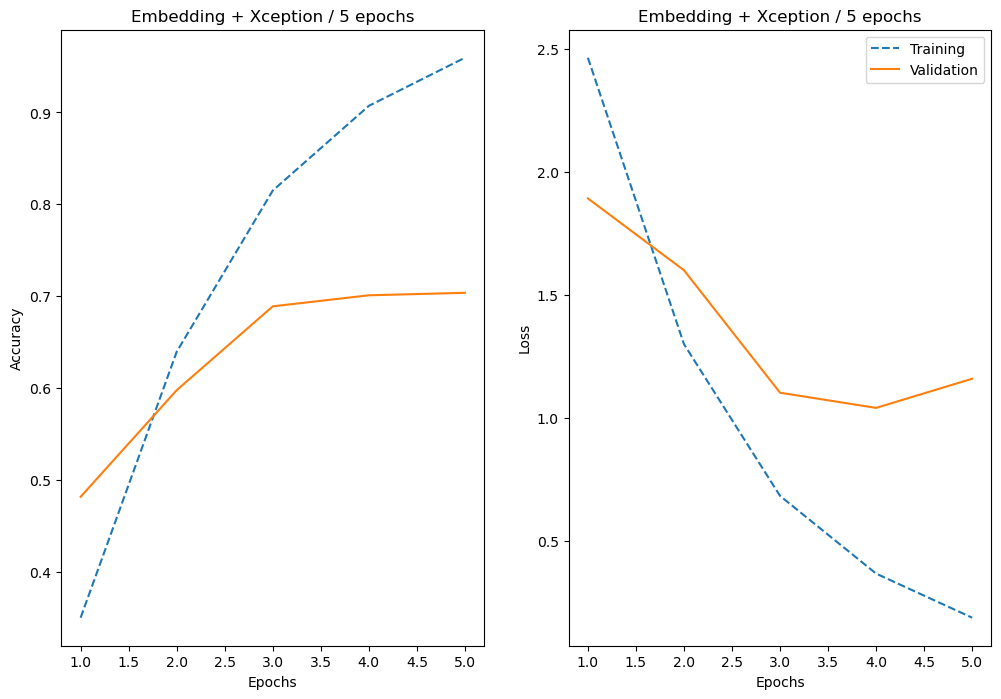

In [47]:
# Visualisation de performances des 3 modèles pendant l'apprentissage
plt.figure(figsize = (12,8))

plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Embedding + Xception / 5 epochs")
plt.plot(epochs,acc, "--", label = "Training " )
plt.plot(epochs,val_acc,label = "Validation")

plt.subplot(122)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Embedding + Xception / 5 epochs")
plt.plot(epochs,loss, "--", label = "Training " )
plt.plot(epochs,val_loss,label = "Validation")

plt.legend();

In [50]:
reload_model = load("../models/Xception_unfreeze105_Embedding100_5ep.joblib")

In [52]:
score = reload_model.evaluate(dataset_test)

print("Accuracy - Modèle Embedding + Xception :",score[1])

160/160 [==============================] - 663s 4s/step - loss: 1.1161 - accuracy: 0.7083
Accuracy - Modèle Embedding + Xception : 0.7083415389060974
